In [1]:
import pandas as pd
import gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.decomposition import LatentDirichletAllocation

# read_file and convert type
data = pd.read_csv('resources/final_processdata2.csv')
data['Processed_Abstracts'] = data['Processed_Abstracts'].astype(str)

In [2]:
# Prepare text data
texts = [doc.split() for doc in data['Processed_Abstracts']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Find optimal number of topics

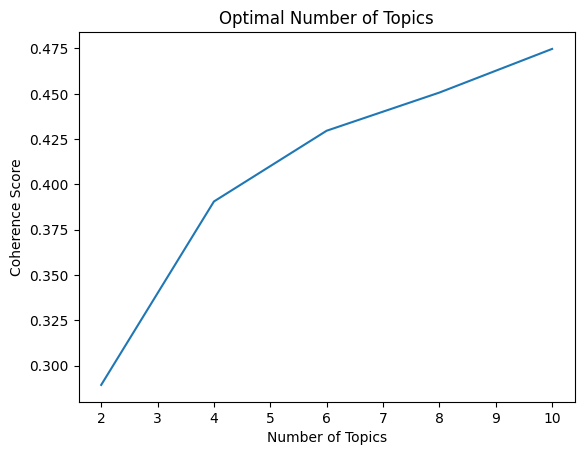

10

In [3]:
import matplotlib.pyplot as plt

# Function to compute coherence for different topic numbers
def compute_coherence_values(dictionary, corpus, texts, start, stop, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=5)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

# Define range for topics
start, stop, step = 2, 12, 2  # Adjust range for quicker runtime

# Compute coherence scores
model_list, coherence_values = compute_coherence_values(dictionary, corpus, texts, start, stop, step)

# Plot coherence values
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.show()

# Find the optimal number of topics
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
optimal_num_topics


In [4]:
# optimal_num_topics = 8

# Fit the optimal LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=optimal_num_topics, id2word=dictionary, passes=10)

# Get top words for each topic
top_words_per_topic = []
for topic_id in range(optimal_num_topics):
    top_words = lda_model.show_topic(topic_id, topn=10)  # Get top 10 words
    top_words_per_topic.append([word for word, _ in top_words])

In [5]:
top_words_per_topic

[['carbon',
  'emissions',
  'energy',
  'study',
  'development',
  'climate',
  'emission',
  'environmental',
  'model',
  'economic'],
 ['ch4',
  'emissions',
  'production',
  'cattle',
  'methane',
  'treatment',
  'respectively',
  'using',
  'kg',
  'diet'],
 ['patients',
  'foam',
  'oil',
  'time',
  'recovery',
  'pressure',
  'co2',
  'injection',
  'concentration',
  'ash'],
 ['carbon',
  'adsorption',
  'using',
  'high',
  'co2',
  'surface',
  'performance',
  'reaction',
  'materials',
  'activated'],
 ['model',
  'flame',
  'flow',
  'data',
  'models',
  'using',
  'results',
  'used',
  'conditions',
  'study'],
 ['carbon',
  'properties',
  'structure',
  'results',
  'different',
  'nanotubes',
  'using',
  'study',
  'used',
  'cnts'],
 ['fuel',
  'emissions',
  'combustion',
  'gas',
  'hydrogen',
  'engine',
  'nox',
  'results',
  'performance',
  'air'],
 ['emissions',
  'co2',
  'carbon',
  'gas',
  'energy',
  'production',
  'global',
  'storage',
  'green

Automate Topic name

In [ ]:
import requests
import os
from dotenv import load_dotenv

load_dotenv()
KEY = os.getenv("APIKEY")
API_KEY = KEY
API_URL = "https://api.opentyphoon.ai/v1/chat/completions"

# Function to generate topic labels using Typhoon API
def generate_topic_label_typhoon(topic_keywords):
    # Refined prompt for descriptive and concise topic labels
    prompt = (
        f"Based on the following keywords, create a concise, descriptive label that summarizes the main topic: "
        f"{', '.join(topic_keywords)}."
    )

    # Construct the payload
    payload = {
        "model": "typhoon-v1.5x-70b-instruct",
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 50,
        "temperature": 0.6,
        "top_p": 0.95,
        "repetition_penalty": 1.05,
        "stream": False
    }

    # Send the request to the Typhoon API
    response = requests.post(
        API_URL,
        headers={
            "Content-Type": "application/json",
            "Authorization": f"Bearer {API_KEY}"
        },
        json=payload
    )

    # Check for successful response
    if response.status_code == 200:
        response_data = response.json()
        label = response_data["choices"][0]["message"]["content"].strip()
        return label
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

# Generate and refine labels for all topics
topic_labels = [generate_topic_label_typhoon(words) for words in top_words_per_topic]

# Print the refined labels in the desired format
for idx, label in enumerate(topic_labels):
    print(f"Topic {idx}: \"{label}\"")




Topic 0: ""Climate and Economic Impact of Carbon Emissions on Energy Development""
Topic 1: ""Methane Emissions Reduction in Cattle through Dietary Treatment""
Topic 2: ""Post-Injection Recovery Techniques for Patients Using Foam, Oil, and CO2""
Topic 3: ""High-Performance Activated Carbon Materials for CO2 Adsorption and Surface Reaction""
Topic 4: ""Modeling Flame Flow under Various Conditions: A Data-Driven Study""
Topic 5: ""Properties and Structure of Carbon Nanotubes (CNTs): A Comparative Study""
Topic 6: "Hydrogen Fuel Engine Performance and Emissions."
Topic 7: "Global Carbon Emissions and Greenhouse Gas Storage in Energy Production"
Topic 8: ""Properties of Carbon Fiber Composites for Enhanced Mechanical Strength""
Topic 9: ""Effects of Increased Organic Carbon and Nitrogen in Forest Soils on Biomass and Water Dynamics: A SOC Study""


Save topic_name

In [7]:
# cutting topic_labels text ""

topic_labels = [label.replace('"', '') for label in topic_labels]
topic_labels

# Save to CSV
df = pd.DataFrame(topic_labels)
df.to_csv('resources/topic_name2.csv', index=False, encoding='utf-8')
print(f"Data saved to 'topic-name2.csv'. Fetched {len(df)} results.")

Data saved to 'topic-name2.csv'. Fetched 10 results.


Save top_words_per_topic

In [8]:
# top_words_per_topic

# data.head()
df = pd.DataFrame(top_words_per_topic)
# Save to CSV
if not df.empty:
    df.to_csv('resources/cleaned_topicdata2.csv', index=False, encoding='utf-8')
    print(f"Data saved to 'cleaned_topicdata2.csv'. Fetched {len(df)} results.")
else:
    print("No data fetched. Check the scraping process.")


Data saved to 'cleaned_topicdata2.csv'. Fetched 10 results.
